### Load dependencies

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models

import matplotlib.pyplot as plt
import h5py




# Configure Keras to use GPU
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.compat.v1.Session(config=config)
tf.compat.v1.keras.backend.set_session(sess)

2024-05-02 15:42:56.635509: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-02 15:42:56.717853: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-02 15:42:56.717912: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-02 15:42:56.720743: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-02 15:42:56.737698: I tensorflow/core/platform/cpu_feature_guar

### Data Loading and processing

In [2]:
with h5py.File('TrainingData5zeroes midpoints.h5', 'r') as hdf:
    ls = list(hdf.keys())
    images = hdf.get('images')
    # boxes = hdf.get('boxes')
    center_coordinates = hdf.get('center_coordinates')
    images = np.array(images)
    # boxes = np.array(boxes)
    center_coordinates = np.array(center_coordinates)

image_normalized = (images + 1e-9) / 9.26
# normalized_boxes = boxes / [1, 64, 64, 64, 64]

images_np = image_normalized
center_coordinates = center_coordinates / [1,64, 64]  # Normalizing the center coordinates
probabilities = np.array(center_coordinates[:,:, :-2])
probabilities = tf.expand_dims(probabilities, axis=1)
center_coordinates_np = np.array(center_coordinates[:, :, 1:])
center_coordinates_np = tf.expand_dims(center_coordinates_np, axis=1)
batch_size = 128
dataset = tf.data.Dataset.from_tensor_slices((images_np, {'x_prob_reshape': probabilities, 'x_midpoints_reshape': center_coordinates_np}))
# dataset = dataset.shuffle(buffer_size=10000).batch(batch_size)
total_items = len(images_np)
train_size = int(total_items * 0.6)
test_size = total_items - train_size 

    # Splitting the dataset
train_dataset = dataset.take(train_size)
test_dataset = dataset.skip(train_size)


train_dataset = train_dataset.shuffle(buffer_size=train_size,reshuffle_each_iteration=True)
train_dataset = train_dataset.batch(batch_size)
test_dataset = test_dataset.batch(batch_size) 

2024-05-02 15:43:01.235972: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 21592 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:68:00.0, compute capability: 8.6


### Model Definition

In [3]:
input_shape = (64,64,1)
num_classes = 280
num_coordinates = 2

x_input = layers.Input(shape=input_shape)
#Layer 1
x = layers.Conv2D(64, kernel_size=3, padding='same', activation='relu')(x_input)
x = layers.MaxPool2D()(x)
x = layers.BatchNormalization()(x) 
x = layers.Conv2D(64, kernel_size=3, padding='same', activation='relu')(x)
#Layer 2
x = layers.Conv2D(128, kernel_size=3, padding='same', activation='relu')(x)
x = layers.Conv2D(128, kernel_size=3, padding='same', activation='relu')(x)
#Layer 3
x = layers.Conv2D(256, kernel_size=3, padding='same', activation='relu')(x)
x = layers.Conv2D(256, kernel_size=3, padding='same', activation='relu')(x)
#Layer 4
x = layers.Conv2D(512, kernel_size=3, padding='same', activation='relu')(x)
x = layers.MaxPool2D()(x)
x = layers.Conv2D(512, kernel_size=3, padding='same', activation='relu')(x)
x = layers.MaxPool2D()(x)
x = layers.Conv2D(512, kernel_size=3, padding='same', activation='relu')(x)
x = layers.MaxPool2D()(x)
#Layer 5
x = layers.Conv2D(256, kernel_size=5, padding='same', activation='relu')(x)
x = layers.MaxPool2D()(x)
x = layers.BatchNormalization()(x) 


x = layers.Flatten()(x)
# Probability output
x_prob = layers.Dense(num_classes, activation='sigmoid', name='x_prob')(x)
x_prob_reshape = layers.Reshape((-1, num_classes, 1), name='x_prob_reshape')(x_prob)

# Bounding box output
x_midpoints = layers.Dense(num_classes * num_coordinates, activation='sigmoid', name='x_midpoints')(x)
x_midpoints_reshape = layers.Reshape((-1, num_classes, num_coordinates), name='x_midpoints_reshape')(x_midpoints)




model = tf.keras.models.Model(x_input, [x_prob_reshape, x_midpoints_reshape])
optimizer = tf.keras.optimizers.Adam(learning_rate=3e-5) 
model.compile(optimizer= optimizer, loss= {'x_prob_reshape': tf.keras.losses.BinaryCrossentropy(), 'x_midpoints_reshape':tf.keras.losses.MeanSquaredError()}, metrics=['accuracy'])    
num_epochs = 2500

Load Trained weights

In [4]:
loadedmodel = tf.keras.models.load_model("/home/m3-learning/Documents/Research Data/Derrick's Object Detection/Models/midpoint3.keras")
# loadmodel = tf.keras.models.load_model("/home/m3-learning/Documents/Research Data/Derrick's Object Detection/Models/Sweep Weights/Train and Val/northern-sweep-1.h5")

In [11]:
# loadedmodel.fit(train_dataset, epochs=num_epochs)

In [22]:
# loadedmodel.save("/home/m3-learning/Documents/Research Data/Derrick's Object Detection/Models/midpoint3.keras")

In [9]:

dataset = tf.data.Dataset.from_tensor_slices((images_np, {'x_prob_reshape': probabilities, 'x_midpoints_reshape': center_coordinates_np}))
# dataset = dataset.batch(1000)
# test_dataset = dataset.take(test_size)
# # test_dataset = test_dataset.shuffle(buffer_size=10000,reshuffle_each_iteration=True)
# test_dataset = test_dataset.batch(test_size)
train_dataset = dataset.take(train_size)
# train_dataset = train_dataset.shuffle(buffer_size=10000,reshuffle_each_iteration=True)
train_dataset = train_dataset.batch(train_size)
inputs,targets = next(iter(train_dataset))
output =loadedmodel.predict(inputs)

188/188 [==============================] - 2s 9ms/step


In [6]:
import tensorflow as tf

r = np.random.randint(0,100)
tensor1 = tf.constant(targets['x_midpoints_reshape'], dtype=tf.float64)

tensor2 = tf.constant(output[1], dtype=tf.float32)


tensor2 = tf.cast(tensor2, tf.float64)


mse_loss_fn = tf.keras.losses.MeanSquaredError()
mse_loss = mse_loss_fn(tensor1, tensor2)

print("MSE Loss:", mse_loss.numpy())

MSE Loss: 3.12054250566933e-05


In [18]:
output[0][90]

array([[[1.00000000e+00],
        [9.99999404e-01],
        [5.41660302e-05],
        [5.41434190e-07],
        [4.56923138e-10],
        [1.19421200e-11],
        [1.37089924e-13],
        [2.22595536e-15],
        [2.03080660e-19],
        [4.07254465e-19],
        [1.95745183e-20],
        [1.84976184e-19],
        [1.14744956e-17],
        [2.21713091e-17],
        [7.05913341e-16],
        [3.19800407e-19],
        [3.47165586e-17],
        [1.27156401e-19],
        [1.15388762e-19],
        [6.83356341e-19],
        [4.31555222e-18],
        [1.61359561e-17],
        [6.87824677e-15],
        [3.79296669e-16],
        [2.25019534e-13],
        [5.21891449e-13],
        [7.83667768e-15],
        [8.80297219e-14],
        [1.40269198e-13],
        [8.42365674e-12],
        [6.10358660e-14],
        [3.14169670e-13],
        [3.48236315e-15],
        [7.20187928e-12],
        [1.01648811e-11],
        [1.05275272e-12],
        [1.31300951e-11],
        [6.74708830e-11],
        [6.9

In [19]:
 
targets['x_prob_reshape'][90]

<tf.Tensor: shape=(1, 280, 1), dtype=float64, numpy=
array([[[1.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [

Conversion From Regression to Classification

In [9]:
# import numpy as np
# import tensorflow as tf

# # Assuming you have loaded the model and the dataset
# dataset = tf.data.Dataset.from_tensor_slices((images_np, {'x_prob_reshape': probabilities, 'x_boxes_reshape': boxes_np}))
# dataset = dataset.batch(301)  # Adjust the batch size according to your needs
# inputs, targets = next(iter(dataset))

# # Predict using the loaded model
# output = loadmodel.predict(inputs)

# # Define thresholds
# # prediction_thresholds = np.array([0.4] * output[1].shape[1])  # Adjust this according to your output dimensions and scale
# # difference_thresholds = np.array([0.1] * output[1].shape[1])  # Adjust this according to what you consider a close enough prediction
# prediction_thresholds = np.array([0.5, 0.5, 0.5, 0.5])
# difference_thresholds = np.array([0.1, 0.1, 0.1, 0.1])

# # # Evaluate predictions function (as previously defined)
# # def evaluate_predictions(y_true, y_pred, pred_thresh, diff_thresh):
# #     predicted_classes = (y_pred > pred_thresh).astype(int)
# #     abs_diff = np.abs(y_pred - y_true)
# #     is_close_enough = abs_diff <= diff_thresh

# #     TP = np.logical_and(predicted_classes == 1, is_close_enough)
# #     FP = np.logical_and(predicted_classes == 1, np.logical_not(is_close_enough))
# #     TN = np.logical_and(predicted_classes == 0, is_close_enough)
# #     FN = np.logical_and(predicted_classes == 0, np.logical_not(is_close_enough))

# #     return np.sum(TP), np.sum(FP), np.sum(TN), np.sum(FN)


# import numpy as np

# def evaluate_predictions(y_true, y_pred, pred_thresh, diff_thresh):
#     predicted_classes = (y_pred > pred_thresh).astype(int)
#     abs_diff = np.abs(y_pred - y_true)
#     is_close_enough = abs_diff <= diff_thresh
    
#     # True Positive: All coordinates must be close enough in a positively predicted sample
#     TP = (predicted_classes == 1) & np.all(is_close_enough, axis=1)
    
#     # False Positive: Any coordinate not close enough in a positively predicted sample
#     FP = (predicted_classes == 1) & ~np.all(is_close_enough, axis=1)
    
#     # True Negative: Predicted as negative (no need to check closeness)
#     TN = (predicted_classes == 0)
    
#     # False Negative: Predicted as negative but should have been positive (based on prediction threshold alone)
#     FN = (predicted_classes == 0) & (y_true > pred_thresh).any(axis=1)
    
#     return np.sum(TP), np.sum(FP), np.sum(TN), np.sum(FN)


# # Assuming 'targets' dictionary contains arrays that match keys with 'output' dictionary keys
# total_TP = total_FP = total_TN = total_FN = 0

# TP, FP, TN, FN = evaluate_predictions(targets['x_boxes_reshape'].numpy(), output[1], prediction_thresholds, difference_thresholds)
# total_TP += TP
# total_FP += FP
# total_TN += TN
# total_FN += FN

# # Calculate precision and recall
# precision = total_TP / (total_TP + total_FP) if (total_TP + total_FP) > 0 else 0
# recall = total_TP / (total_TP + total_FN) if (total_TP + total_FN) > 0 else 0

# # Calculate F1 score
# if (precision + recall) > 0:
#     f1_score = 2 * (precision * recall) / (precision + recall)
# else:
#     f1_score = 0

# print(f'Precision: {precision}, Recall: {recall}, F1 Score: {f1_score}')


10/10 [==============================] - 0s 8ms/step
Precision: 0.8820072711959346, Recall: 0.5789277967271784, F1 Score: 0.6990297343422884


In [ ]:
# def visualize_bounding_boxes(image, probability_vector, bounding_box_coordinates, threshold=0.9):
#     """
#     Visualizes bounding boxes on an image based on a probability vector.

#     Parameters:
#     - image: A 3D tensor representing the image.
#     - probability_vector: A 1D tensor representing the probabilities associated with bounding boxes.
#     - bounding_box_coordinates: A 2D tensor representing bounding box coordinates.
#     - threshold: Probability threshold for visualization.

#     Returns:
#     None (displays the image with bounding boxes).
#     """
#     # Convert to NumPy arrays for easier handling
#     image_np = image
#     prob_vector_np = probability_vector
#     bbox_coordinates_np = bounding_box_coordinates
#    # Denormalize image if necessary (adjust based on your normalization method)
#     denormalized_image = image_np  # Modify if normalization was applied during training

#     # Visualize the image
#     plt.figure(figsize=(4, 4))
#     plt.imshow(denormalized_image, cmap='gray')
#     plt.title("Bounding Box Visualization")

#     # Plot bounding boxes based on probability threshold
#     for i in range(len(prob_vector_np)):
#         prob = prob_vector_np[i]
#         bbox = bbox_coordinates_np[i]
#         if prob > threshold:
#             # Denormalize bounding box coordinates if necessary
#             denormalized_bbox = bbox  # Modify if normalization was applied during training
#             y1, x1, y2, x2 = denormalized_bbox
#             plt.plot([x1, x2, x2, x1, x1],[y1, y1, y2, y2, y1],
                     
#                      color='r', linewidth=2, label='Bounding Box')

   






   
#     plt.show()

# t = np.random.randint(0,200)
# # probabilities = tf.convert_to_tensor(output[0][t,:])

# visualize_bounding_boxes(tf.convert_to_tensor(inputs[t]), probabilities.numpy()[t].squeeze(), tf.convert_to_tensor(output[1][t,0,:,:])*[64,64,64,64]) ##myprediction
# visualize_bounding_boxes(tf.convert_to_tensor(image_normalized[t]), probabilities.numpy()[t].squeeze(), tf.convert_to_tensor(boxes_np[t,0,:,:])*[64,64,64,64]) ##myprediction


In [46]:
output[1][2].shape

(1, 280, 2)

Visualisation

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


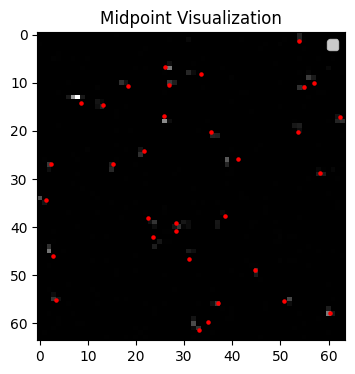

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


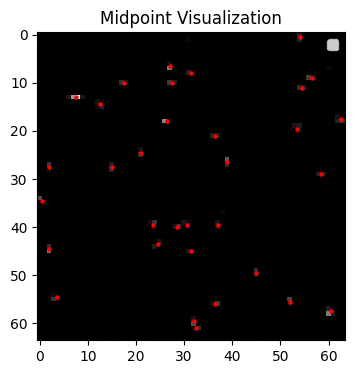

In [7]:
import numpy as np
import matplotlib.pyplot as plt

def visualize_midpoints(image, probability_vector, midpoints, threshold=0.8):
    """
    Visualizes midpoints on an image based on a probability vector.

    Parameters:
    - image: A 3D tensor representing the image.
    - probability_vector: A 1D tensor representing the probabilities associated with midpoints.
    - midpoints: A 2D tensor representing the midpoint coordinates (x, y).
    - threshold: Probability threshold for visualization.

    Returns:
    None (displays the image with midpoints).
    """
    # Convert to NumPy arrays for easier handling
    image_np = image
    prob_vector_np = probability_vector
    midpoints_np = midpoints#.numpy() if hasattr(midpoints, 'numpy') else midpoints

    # Denormalize image if necessary (adjust based on your normalization method)
    denormalized_image = image_np  # Modify if normalization was applied during training

    # Visualize the image
    plt.figure(figsize=(4, 4))
    plt.imshow(denormalized_image, cmap='gray')
    plt.title("Midpoint Visualization")

    # Plot midpoints based on probability threshold
    for i, (y,x) in enumerate(midpoints_np):
        prob = prob_vector_np[i]
        if prob > threshold:
            plt.scatter(x, y, color='red', s=5)
            if i == 0:  # Add label only once to avoid repetition in the legend
                plt.legend()

    plt.show()

t = np.random.randint(0,2000)

visualize_midpoints(tf.convert_to_tensor(inputs[t]), probabilities[t].numpy().squeeze(), tf.convert_to_tensor(output[1][t,0,:,:])*[64,64]) ##myprediction      
visualize_midpoints(tf.convert_to_tensor(images_np[t]), probabilities[t].numpy().squeeze(), tf.convert_to_tensor(center_coordinates_np[t,0,:,:])*[64,64]) ##myprediction           




Evaluation Metrics

In [20]:
# import numpy as np

# def evaluate_model(predictions, ground_truths, probability_threshold=0.9, midpoint_diff_threshold=0.1):
#     pred_probabilities = predictions[0]
#     pred_midpoints = predictions[1]
#     gt_probabilities = ground_truths[0]  # Access the first element of the list, assuming it's probabilities
#     gt_midpoints = ground_truths[1]  # Access the second element of the list, assuming it's midpoints
    
#     # Determine valid predicted boxes based on probability threshold
#     valid_predictions = pred_probabilities > probability_threshold
    
#     # Calculate the absolute difference between predicted and ground truth midpoints
#     midpoint_diff = np.abs(pred_midpoints - gt_midpoints)
    
#     # Check if the midpoint differences are within the allowed threshold
#     is_accurate_prediction = np.all(midpoint_diff <= midpoint_diff_threshold, axis=1)
    
#     # True Positives: Predictions that are valid and close enough to the ground truth
#     TP = np.sum(np.logical_and(valid_predictions, is_accurate_prediction))
    
#     # False Positives: Predictions that are valid but not close enough to the ground truth
#     FP = np.sum(np.logical_and(valid_predictions, ~is_accurate_prediction))
    
#     # False Negatives: Ground truth boxes that were not predicted accurately
#     FN = np.sum(np.logical_and(~valid_predictions, gt_probabilities > probability_threshold))
    
#     # Calculate precision and recall
#     precision = TP / (TP + FP) if (TP + FP) > 0 else 0
#     recall = TP / (TP + FN) if (TP + FN) > 0 else 0
    
#     # Calculate F1 score
#     F1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    
#     # Calculate Mean Absolute Error (MAE) for midpoints
#     MAE = np.mean(midpoint_diff)
    
#     return precision, recall, F1_score, MAE

# # Usage example
# predictions = [output[0], output[1]]  # output[0] are the probabilities, output[1] are the midpoints
# ground_truths = [targets['x_prob_reshape'], targets['x_midpoints_reshape']]
# precision, recall, F1_score, MAE = evaluate_model(predictions, ground_truths)

# print(f"Precision: {precision}, Recall: {recall}, F1 Score: {F1_score}, MAE: {MAE}")


In [10]:
import numpy as np

def evaluate_model(predictions, ground_truths, probability_threshold=0.9, midpoint_diff_threshold=0.1):
    pred_probabilities = predictions[0]
    pred_midpoints = predictions[1]
    gt_probabilities = ground_truths[0]
    gt_midpoints = ground_truths[1]
    
    # Valid predictions are those above the probability threshold
    valid_predictions = pred_probabilities > probability_threshold
    no_predictions = pred_probabilities <= probability_threshold

    # Calculate differences for midpoint evaluations
    midpoint_diff = np.abs(pred_midpoints - gt_midpoints)
    is_accurate_prediction = np.all(midpoint_diff <= midpoint_diff_threshold, axis=1)
    
    # True Positives: Valid predictions close enough to the ground truth
    TP = np.sum(np.logical_and(valid_predictions, is_accurate_prediction))
    
    # False Positives: Valid predictions not close enough to the ground truth
    FP = np.sum(np.logical_and(valid_predictions, ~is_accurate_prediction))
    
    # True Negatives: No predictions where no objects are actually present
    TN = np.sum(np.logical_and(no_predictions, gt_probabilities <= probability_threshold))
    
    # False Negatives: No predictions where objects are actually present
    FN = np.sum(np.logical_and(no_predictions, gt_probabilities > probability_threshold))
    
    # Metrics calculation
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0
    F1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    MAE = np.mean(midpoint_diff)
    
    return precision, recall, F1_score, MAE

# Usage example
predictions = [output[0], output[1]]
ground_truths = [targets['x_prob_reshape'], targets['x_midpoints_reshape']]
precision, recall, F1_score, MAE = evaluate_model(predictions, ground_truths)

print(f"Precision: {precision}, Recall: {recall}, F1 Score: {F1_score}, MAE: {MAE}")


Precision: 0.9999988735609671, Recall: 1.0, F1 Score: 0.9999994367801663, MAE: 0.002802788392285744


In [11]:
# import numpy as np

# # Random seed for reproducibility
# np.random.seed(42)

# # Number of samples
# n_samples = 10

# # Generate dummy predictions
# predicted_probabilities = np.random.rand(n_samples)
# predicted_midpoints = np.random.rand(n_samples, 2)  # 2D coordinates (x, y)

# # Generate dummy ground truths
# ground_truth_probabilities = np.random.rand(n_samples)
# # Midpoints close to the predicted ones with small random noise added
# ground_truth_midpoints = predicted_midpoints + np.random.normal(0, 0.05, (n_samples, 2))

# # Package predictions and ground truths
# predictions = [predicted_probabilities, predicted_midpoints]
# ground_truths = [ground_truth_probabilities, ground_truth_midpoints]

# # Print out the arrays
# print("Predicted Probabilities:", predicted_probabilities)
# print("Predicted Midpoints:", predicted_midpoints)
# print("Ground Truth Probabilities:", ground_truth_probabilities)
# print("Ground Truth Midpoints:", ground_truth_midpoints)

# # Function call
# precision, recall, F1_score, MAE, TP,FP,FN,TN = evaluate_model(predictions, ground_truths)

# # Print results
# print(f"Precision: {precision}, Recall: {recall}, F1 Score: {F1_score}, MAE: {MAE}, True Negatives: {TN}", f"True Positives: {TP}, False Positives: {FP}, False Negatives: {FN}")


In [31]:
# import numpy as np

# # Sample predictions and ground truth data
# pred_probabilities = np.array([0.6, 0.4, 0.8, 0.1])
# pred_midpoints = np.array([[0.5, 0.5], [0.2, 0.1], [0.6, 0.7], [0.4, 0.4]])

# gt_probabilities = np.array([0.7, 0.0, 0.9, 0.0])
# gt_midpoints = np.array([[0.52, 0.48], [0.0, 0.0], [0.58, 0.72], [0.0, 0.0]])

# # Using the function
# predictions = [pred_probabilities, pred_midpoints]
# ground_truths = [gt_probabilities, gt_midpoints]

# precision, recall, F1_score, MAE, TN, TP, FP, FN = evaluate_model(predictions, ground_truths)

# print(f"Precision: {precision}, Recall: {recall}, F1 Score: {F1_score}, MAE: {MAE}")
# print(f"True Negatives: {TN}, True Positives: {TP}, False Positives: {FP}, False Negatives: {FN}")


Precision: 1.0, Recall: 1.0, F1 Score: 1.0, MAE: 0.14750000000000002
True Negatives: 2, True Positives: 2, False Positives: 0, False Negatives: 0


In [12]:

model = faster_rcnn_fcn(kernel = 3, pretrained = True, num_classes=2, weights_path='/home/m3-learning/Documents/TinySegResNet_statedict_k3nearest.tar',
                        setting_dict=mask_hp).to('cuda')

NameError: name 'faster_rcnn_fcn' is not defined